### finding the crop width and height

In [ ]:
import cv2

# Load the video and get a single frame
video_path = './datasets/mobile-videos/muted_1.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    # Interactive ROI selection
    roi = cv2.selectROI("Select ROI", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyAllWindows()
    
    # Extract ROI values
    CROP_X, CROP_Y, CROP_WIDTH, CROP_HEIGHT = int(roi[0]), int(roi[1]), int(roi[2]), int(roi[3])
    print(f"Selected ROI - X: {CROP_X}, Y: {CROP_Y}, Width: {CROP_WIDTH}, Height: {CROP_HEIGHT}")
else:
    print("Error: Cannot read frame.")


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


2024-12-21 10:28:01.770 python[26796:7835743] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-21 10:28:01.770 python[26796:7835743] +[IMKInputSession subclass]: chose IMKInputSession_Modern


**using the above code, the region of interest was identified and it was noted down below.
based on that the videos were cropped using the code and saved inside the datasets/mobile-videos with the prefix "cropped"**

In [15]:
CROP_X = 357
CROP_Y = 256
CROP_WIDTH = 574  
CROP_HEIGHT = 1002 

### cropping

In [ ]:
# import cv2
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# # Define video paths
# video_dir = './datasets/mobile-videos'
# videos = ["muted_1.mp4", "muted_2.mp4", "muted_3.mp4"]

# # Define output directory
# output_dir = './datasets/mobile-videos'
# os.makedirs(output_dir, exist_ok=True)

# # Define a cropping region of interest (ROI)
# # defined in above cell

# # Helper function to visualize a frame
# def display_frame(frame, title="Frame"):
#     plt.figure(figsize=(10, 6))
#     plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # Process each video
# for video_name in videos:
#     video_path = os.path.join(video_dir, video_name)
#     cap = cv2.VideoCapture(video_path)
    
#     if not cap.isOpened():
#         print(f"Error: Cannot open {video_name}")
#         continue

#     frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = int(cap.get(cv2.CAP_PROP_FPS))
#     num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     print(f"Processing {video_name} - {frame_width}x{frame_height}, {fps} FPS, {num_frames} frames")

#     # Output video writer
#     output_video_path = os.path.join(output_dir, f"cropped_{video_name}")
#     out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps,
#                           (CROP_WIDTH, CROP_HEIGHT))

#     frame_idx = 0
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Crop the frame
#         frame = frame[CROP_Y:CROP_Y + CROP_HEIGHT, CROP_X:CROP_X + CROP_WIDTH]
#         processed_frame = cropped_frame

#         # Write the processed frame
#         out.write(processed_frame)


#         frame_idx += 1

#     cap.release()
#     out.release()
#     print(f"Finished processing {video_name}. Saved to {output_video_path}")


### pre processing

#### helper functions

In [27]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Helper function to visualize a frame
def display_frame(frame, title="Frame"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()
    
def print_video_details(cap,video_name):
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing {video_name} - {frame_width}x{frame_height}, {fps} FPS, {num_frames} frames")
    return fps

#### pre processing functions

In [12]:
# Define noise reduction parameters
GAUSSIAN_KERNEL_SIZE = (5, 5)  # Size for Gaussian blur
MEDIAN_KERNEL_SIZE = 5  # Kernel size for Median blur
BILATERAL_FILTER_PARAMS = (9, 75, 75)  # Diameter, SigmaColor, SigmaSpace

# Morphological kernel
MORPH_KERNEL = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

def noice_reduction(frame):
        # Apply Gaussian blur
        processed_frame = cv2.GaussianBlur(frame, GAUSSIAN_KERNEL_SIZE, 0)

        # Apply Median blur
        processed_frame = cv2.medianBlur(processed_frame, MEDIAN_KERNEL_SIZE)

        # Apply Bilateral Filtering
        processed_frame = cv2.bilateralFilter(processed_frame, *BILATERAL_FILTER_PARAMS)
        
        return processed_frame

def background_sub(frame):
        # Initialize Background Subtractor
        bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=1500, varThreshold=50, detectShadows=False)

        # Morphological kernel
        MORPH_KERNEL = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        
        fg_mask = bg_subtractor.apply(frame)
        
        # Post-process the mask
        cleaned_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, MORPH_KERNEL)

        # Combine the mask with the original frame
        processed_frame = cv2.bitwise_and(frame, frame, mask=cleaned_mask)
        
        return processed_frame


#### script run for pre processing

In [14]:
# Define video paths
video_dir = './datasets/mobile-videos'
# videos = ["cropped_muted_1.mp4", "cropped_muted_2.mp4", "cropped_muted_3.mp4"]
videos = ["cropped_muted_1.mp4"]

# Define output directory
output_dir = './datasets/pre-processed-mobile-videos'
os.makedirs(output_dir, exist_ok=True)


# Process each video
for video_name in videos:
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open {video_name}")
        continue

    fps = print_video_details(cap,video_name)

    # Output video writer
    output_video_path = os.path.join(output_dir, f"pre-processed_{video_name}")
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps,
                          (CROP_WIDTH, CROP_HEIGHT))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # single function to pre process
        # processed_frame = noice_reduction(frame) # noice reduction is not working
        processed_frame = background_sub(frame)

        # Write the processed frame
        out.write(processed_frame)

        ## Display every 1000th frame
        # if frame_idx % 10000 == 0:
            # display_frame(processed_frame, title=f"Processed Frame {frame_idx}")

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Finished processing {video_name}. Saved to {output_video_path}")


Processing cropped_muted_1.mp4 - 574x1002, 29 FPS, 413 frames
Finished processing cropped_muted_1.mp4. Saved to ./datasets/pre-processed-mobile-videos/pre-processed_cropped_muted_1.mp4


### trying out pre processing for specific frames

#### getting frames and saving in a new folder

In [19]:
import os
import cv2

# Define video paths
video_dir = './datasets/mobile-videos'
videos = ["cropped_muted_1.mp4"]

# Define output directory for frames
frame_output_dir = './datasets/video-frames'
os.makedirs(frame_output_dir, exist_ok=True)

# Frame saving configuration
SAVE_EVERY_NTH_FRAME = 10  # Save every Nth frame
SPECIFIC_FRAME_INDEXES = []  # Add specific frame indexes to save, e.g., [10, 500, 1000]

# Process each video
for video_name in videos:
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open {video_name}")
        continue

    # Get video details
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing {video_name} - {fps} FPS, {total_frames} total frames")

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame as PNG based on conditions
        if frame_idx % SAVE_EVERY_NTH_FRAME == 0 or frame_idx in SPECIFIC_FRAME_INDEXES:
            frame_filename = f"{os.path.splitext(video_name)[0]}_frame_{frame_idx}.png"
            frame_output_path = os.path.join(frame_output_dir, frame_filename)

            # Save the frame
            cv2.imwrite(frame_output_path, frame)
            print(f"Saved: {frame_output_path}")

        frame_idx += 1

    cap.release()
    print(f"Finished processing {video_name}. Frames saved to {frame_output_dir}")


Processing cropped_muted_1.mp4 - 29 FPS, 413 total frames
Saved: ./datasets/video-frames/cropped_muted_1_frame_0.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_10.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_20.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_30.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_40.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_50.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_60.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_70.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_80.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_90.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_100.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_110.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_120.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_130.png
Saved: ./datasets/video-frames/cropped_muted_1_frame_140.png
Saved: ./datasets/video-frames/cropped

#### analysing frame(s)

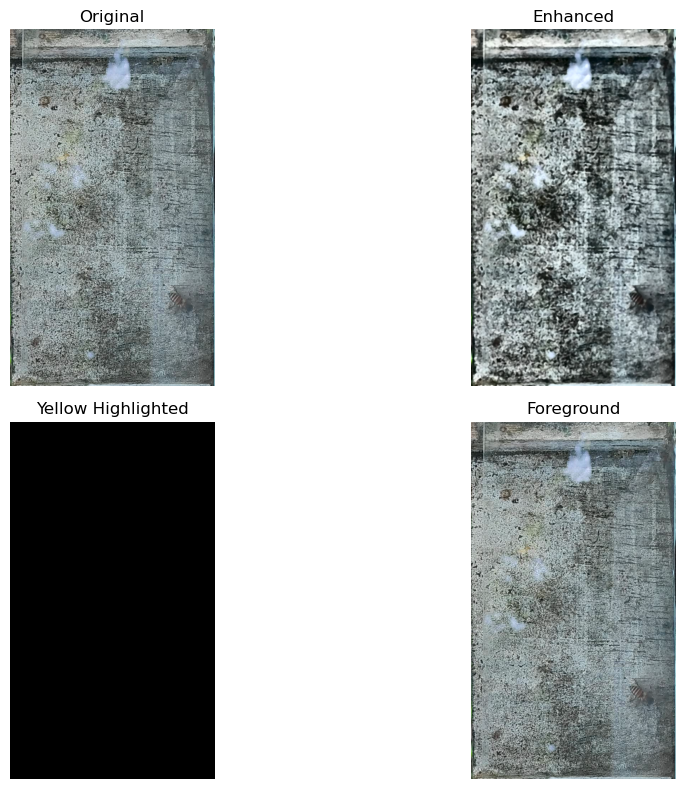

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Frame directory
frame_input_dir = './datasets/video-frames'
processed_output_dir = './datasets/processed-frames'
os.makedirs(processed_output_dir, exist_ok=True)

# Select image index to process
selected_image_index = 1  # Change this to the desired frame index

# Get all image files from the directory
image_files = sorted([f for f in os.listdir(frame_input_dir) if f.endswith('.png')])
if not image_files:
    print("No images found in the directory.")
else:
    # Ensure the selected index is within range
    if selected_image_index < 1 or selected_image_index > len(image_files):
        print(f"Invalid index. Please select a value between 1 and {len(image_files)}.")
    else:
        # Load the selected image
        selected_image_path = os.path.join(frame_input_dir, image_files[selected_image_index - 1])
        frame = cv2.imread(selected_image_path)

        if frame is None:
            print(f"Error: Could not read the image {selected_image_path}")
        else:
            # 1. Original frame (no cropping needed in this case)
            original_frame = frame

            # 2. Noise Reduction
            gaussian_blurred = cv2.GaussianBlur(original_frame, (5, 5), 0)
            median_blurred = cv2.medianBlur(gaussian_blurred, 5)

            # 3. Contrast and Brightness Adjustment
            # Convert to LAB color space for brightness normalization
            lab = cv2.cvtColor(median_blurred, cv2.COLOR_BGR2LAB)
            l_channel, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            l_channel = clahe.apply(l_channel)
            enhanced_frame = cv2.merge((l_channel, a, b))
            enhanced_frame = cv2.cvtColor(enhanced_frame, cv2.COLOR_LAB2BGR)

            # 4. Color Thresholding (Focus on yellow for pollen detection)
            hsv = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2HSV)
            lower_yellow = np.array([20, 100, 100])  # Adjust thresholds for yellow
            upper_yellow = np.array([30, 255, 255])
            mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

            # Combine mask with the original frame
            yellow_highlighted = cv2.bitwise_and(original_frame, original_frame, mask=mask_yellow)

            # 5. Background Subtraction (Optional if dynamic objects only)
            bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=False)
            fg_mask = bg_subtractor.apply(original_frame)
            fg_cleaned = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

            # 6. Combine Foreground Mask
            foreground = cv2.bitwise_and(original_frame, original_frame, mask=fg_cleaned)

            # Save the processed frame
            output_path = os.path.join(processed_output_dir, f"processed_{image_files[selected_image_index - 1]}")
            cv2.imwrite(output_path, yellow_highlighted)

            # Display intermediate results
            plt.figure(figsize=(12, 8))
            titles = ['Original', 'Enhanced', 'Yellow Highlighted', 'Foreground']
            images = [original_frame, enhanced_frame, yellow_highlighted, foreground]
            for i in range(4):
                plt.subplot(2, 2, i + 1)
                plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
                plt.title(titles[i])
                plt.axis('off')
            plt.tight_layout()
            plt.show()


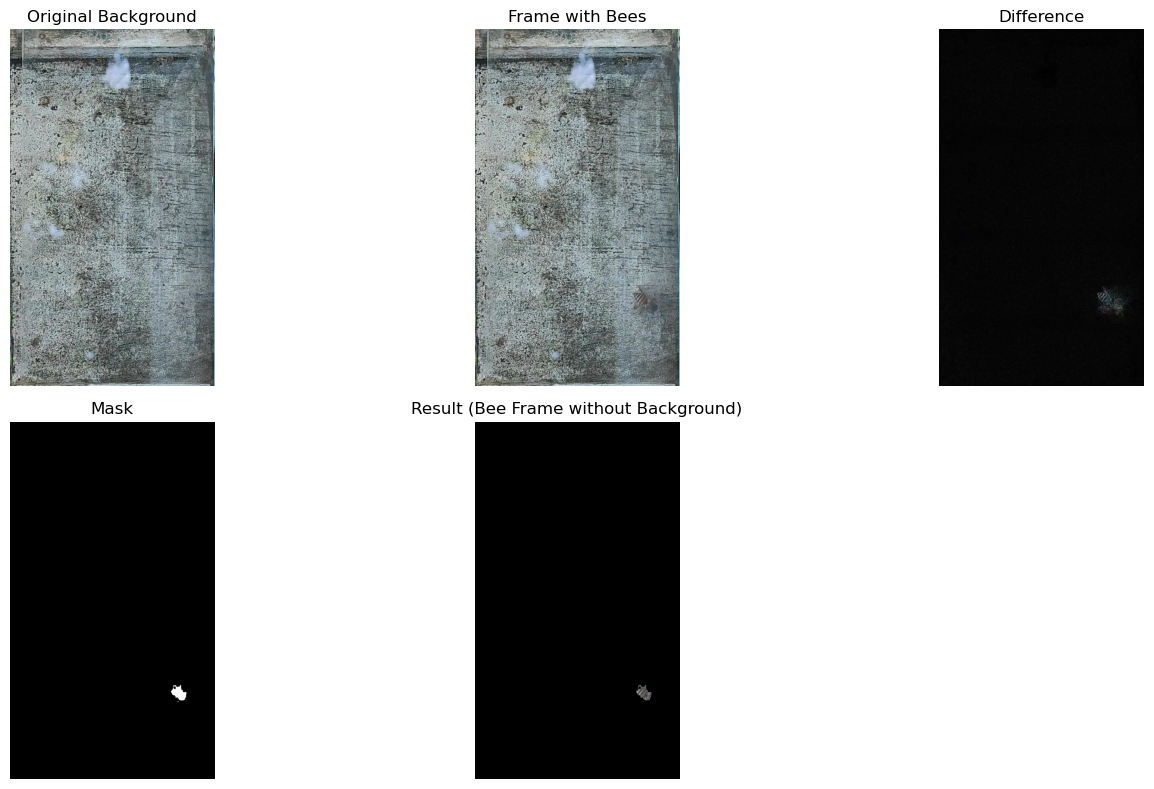

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to images
background_image_path = './datasets/video-frames/background.png'  # Frame with just the background
bee_frame_path = './datasets/video-frames/frame_with_bees.png'    # Frame with bees

# Load images
background = cv2.imread(background_image_path)
bee_frame = cv2.imread(bee_frame_path)

# Ensure images are the same size
if background.shape != bee_frame.shape:
    print("Error: Background and bee frame must have the same dimensions.")
else:
    # Subtract the background directly in color
    diff = cv2.absdiff(bee_frame, background)

    # Convert to HSV for better color thresholding
    hsv_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2HSV)

    # Threshold based on intensity of difference
    lower_threshold = np.array([0, 50, 50])  # Adjust for your lighting conditions
    upper_threshold = np.array([255, 255, 255])
    mask = cv2.inRange(hsv_diff, lower_threshold, upper_threshold)

    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Apply the mask to the original bee frame
    result = cv2.bitwise_and(bee_frame, bee_frame, mask=cleaned_mask)

    # Display results
    plt.figure(figsize=(15, 8))
    titles = ['Original Background', 'Frame with Bees', 'Difference', 'Mask', 'Result (Bee Frame without Background)']
    images = [background, bee_frame, diff, cleaned_mask, result]
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Optionally save the result
    cv2.imwrite('./datasets/processed-frames/bee_foreground.png', result)


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths to images
background_image_path = './datasets/video-frames/background.png'  # Frame with just the background
background = cv2.imread(background_image_path)

def cleanup1(frame):
    # Ensure images are the same size
    if background.shape != frame.shape:
        print("Error: Background and bee frame must have the same dimensions.")
    else:
        # Subtract the background directly in color
        diff = cv2.absdiff(frame, background)

        # # Convert to HSV for better color thresholding
        hsv_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2HSV)

        # Threshold based on intensity of difference
        lower_threshold = np.array([0, 50, 50])  # Adjust for your lighting conditions
        upper_threshold = np.array([255, 255, 255])
        mask = cv2.inRange(hsv_diff, lower_threshold, upper_threshold)

        # Morphological operations to clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        cleaned_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Apply the mask to the original bee frame
        result = cv2.bitwise_and(frame, frame, mask=cleaned_mask)
        # return result #---------------------------------------------------------------------------
        ##can try out both of the options 
        return diff
        
    


In [22]:
# Define video paths
video_dir = './datasets/mobile-videos'
# videos = ["cropped_muted_1.mp4", "cropped_muted_2.mp4", "cropped_muted_3.mp4"]
videos = ["cropped_muted_1.mp4"]

# Define output directory
output_dir = './datasets/pre-processed-mobile-videos'
os.makedirs(output_dir, exist_ok=True)


# Process each video
for video_name in videos:
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open {video_name}")
        continue

    # fps = print_video_details(cap,video_name)

    # Output video writer
    output_video_path = os.path.join(output_dir, f"hash-pre-processed_{video_name}")
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 29,
                          (CROP_WIDTH, CROP_HEIGHT))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        processed_frame = cleanup1(frame)

        # Write the processed frame
        out.write(processed_frame)

        ## Display every 1000th frame
        # if frame_idx % 10000 == 0:
            # display_frame(processed_frame, title=f"Processed Frame {frame_idx}")

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Finished processing {video_name}. Saved to {output_video_path}")


Finished processing cropped_muted_1.mp4. Saved to ./datasets/pre-processed-mobile-videos/hash-pre-processed_cropped_muted_1.mp4


### enhance red yellow orange -ish collors - more pre processing 

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths to images
background_image_path = './datasets/video-frames/background.png'  # Frame with just the background
background = cv2.imread(background_image_path)

def cleanup(frame, suppress_others=False, enlarge=False, kernel_size=7, iterations=3):
    # Ensure images are the same size
    if background.shape != frame.shape:
        print("Error: Background and bee frame must have the same dimensions.")
        return
    else:
        # Subtract the background directly in color
        diff = cv2.absdiff(frame, background)

        # Convert diff to HSV
        hsv_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2HSV)

        # Define HSV ranges for red, yellow, and orange
        lower_red1 = np.array([0, 100, 100])     # Lower range for red (hue 0-10)
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 100])   # Upper range for red (hue 160-180)
        upper_red2 = np.array([180, 255, 255])
        lower_yellow = np.array([20, 100, 100])  # Range for yellow
        upper_yellow = np.array([30, 255, 255])
        lower_orange = np.array([10, 100, 100])  # Range for orange
        upper_orange = np.array([20, 255, 255])

        # Create masks for each color
        red_mask1 = cv2.inRange(hsv_diff, lower_red1, upper_red1)
        red_mask2 = cv2.inRange(hsv_diff, lower_red2, upper_red2)
        yellow_mask = cv2.inRange(hsv_diff, lower_yellow, upper_yellow)
        orange_mask = cv2.inRange(hsv_diff, lower_orange, upper_orange)

        # Combine all masks
        combined_mask = cv2.bitwise_or(red_mask1, red_mask2)
        combined_mask = cv2.bitwise_or(combined_mask, yellow_mask)
        combined_mask = cv2.bitwise_or(combined_mask, orange_mask)

        if enlarge:
            # Dilate the mask to enlarge the regions
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
            combined_mask = cv2.dilate(combined_mask, kernel, iterations=iterations)

        # Enhance the selected regions
        enhanced = cv2.addWeighted(diff, 1.0, diff, 0.5, 0)
        enhanced_regions = cv2.bitwise_and(enhanced, enhanced, mask=combined_mask)

        if suppress_others:
            # Suppress non-target colors
            inverse_mask = cv2.bitwise_not(combined_mask)  # Non-target areas
            suppressed = cv2.addWeighted(diff, 0.5, diff, 0.0, 0)  # Reduce intensity of non-target areas
            suppressed_regions = cv2.bitwise_and(suppressed, suppressed, mask=inverse_mask)

            # Combine enhanced and suppressed regions
            final_result = cv2.addWeighted(enhanced_regions, 1.0, suppressed_regions, 1.0, 0)
        else:
            final_result = enhanced_regions

        return final_result



        
# Define video paths
video_dir = './datasets/mobile-videos'
videos = ["cropped_muted_1.mp4"]

# Define output directory
output_dir = './datasets/pre-processed-mobile-videos'
os.makedirs(output_dir, exist_ok=True)


# Process each video
for video_name in videos:
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open {video_name}")
        continue


    # Output video writer
    output_video_path = os.path.join(output_dir, f"yellow-en-pre-processed_{video_name}")
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 29, # 29 can be given as an return value of the pirnt_details method
                          (CROP_WIDTH, CROP_HEIGHT))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        processed_frame = cleanup(frame, suppress_others=True, enlarge=True)

        # Write the processed frame
        out.write(processed_frame)

        # # Display every 1000th frame
        # if frame_idx % 200 == 0:
        #     display_frame(processed_frame, title=f"Processed Frame {frame_idx}")

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Finished processing {video_name}. Saved to {output_video_path}")

    


Finished processing cropped_muted_1.mp4. Saved to ./datasets/pre-processed-mobile-videos/yellow-en-pre-processed_cropped_muted_1.mp4
